# Lesson 7 - Parkinson PCR

## Author - Rodolfo Lerma

# Abstract:

The analysis is is divided the following way:

### First look at the data:
- **Variables that will be used for analysis**
- **Outlier detection**

### Analysis:
- **PCA**
- **Linear Regression**

### Summary/conclusions:

In [1]:
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"
#filename = "parkinsons_updrs.data"

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns

# First look at the data

In [3]:
parkinsons_df = pd.read_csv(filename)
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
parkinsons_df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

## Variables that will be used for analysis

In [5]:
# Define the target and features:
target_label = 'total_UPDRS'
#non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
non_features = ['subject#', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in parkinsons_df.columns if x not in [target_label] + non_features]
print(feature_labels)

['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


In [6]:
# Filter out non-features and non-targets
parkinsons_df = parkinsons_df.drop(non_features, axis=1)

# One-hot encode inputs
parkinsons_expanded = pd.get_dummies(parkinsons_df, drop_first=True)
print('DataFrame one-hot-expanded shape: {}'.format(parkinsons_expanded.shape))

DataFrame one-hot-expanded shape: (5875, 19)


The following variables were removed from the data frame as they are not going to be included in the regression model:
- `subject#`
- `test_time`
- `motor_UPDRS`


## Outlier detection

In this section of the analysis outliers would be detected and removed. Even though around 900 data points will be removed, we still ended up with a relatively good number to work with (4954 data points)

In [7]:
#Remove outliers
columns = ['total_UPDRS','age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
for i in columns:
    #Removing outliers based on Price:
    LimitHi = np.mean(parkinsons_df[i]) + 3*np.std(parkinsons_df[i]) #Higher Limit for each of the numeric attributes
    LimitLo = np.mean(parkinsons_df[i]) - 3*np.std(parkinsons_df[i]) #Lower Limit for each of the numeric attributes
    FlagBad = (parkinsons_df[i] < LimitLo) | (parkinsons_df[i] > LimitHi) #Boolean for values outside limits
    FlagGood = ~FlagBad #Complement
    parkinsons_df = parkinsons_df.loc[FlagGood]
    
print(parkinsons_df.shape)

(4954, 19)


# Analysis

In [8]:
# Get target and original x-matrix
y = parkinsons_df[target_label]
X = parkinsons_df.as_matrix(columns=feature_labels)
columns2 = ['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
x_frame = parkinsons_df[columns2]

C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

In [10]:
# Scale all columns first
x_scaled = np.apply_along_axis(scale, 0, X)

# Create a scaled y-target.
y_scaled = np.apply_along_axis(scale, 0, y)

## PCA

In [11]:
# PCR
#pca = PCA(n_components = 2)
pca = PCA()
pca_result = pca.fit_transform(x_scaled)
column_names = ['pc' + str(ix+1) for ix in range(x_scaled.shape[1])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target_label] = y_scaled

In [12]:
print(pca_df.head(3))
print(pca_df.shape)

        pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0  0.446421  1.015824  1.451785 -0.720888 -0.786429  2.037138 -1.169392   
1 -3.343537 -1.022952 -0.013265 -0.858700 -0.882142  0.964695 -0.367749   
2 -2.022894  0.721739  0.116645 -1.663593 -0.489555  0.930132  0.577598   

        pc8       pc9      pc10      pc11      pc12      pc13      pc14  \
0 -0.172061 -1.461803 -0.321648  0.361576  0.247960  0.197491 -0.057043   
1  0.302879  0.125594 -0.016259  0.143423 -0.088746 -0.030121 -0.100282   
2 -0.209069 -0.631846 -0.171455  0.275673  0.106070  0.309611 -0.021110   

       pc15      pc16      pc17      pc18  total_UPDRS  
0  0.057065  0.057847 -0.002351 -0.000042     0.488587  
1  0.110229  0.032040  0.002313  0.000009     0.534555  
2 -0.034161  0.017071 -0.002084 -0.000016     0.580430  
(4954, 19)


In [13]:
exp_var = pca.explained_variance_
components = pca.components_

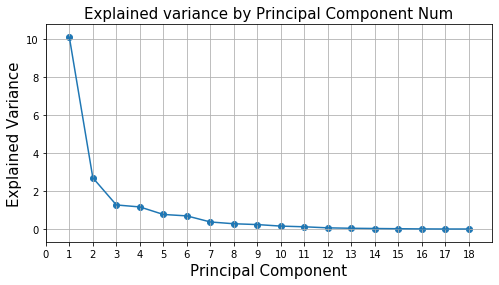

In [14]:
# Plot the explained variance for all principal components.
# Note: If the first value is too large, it may dwarf how the rest look.
# You may consider plotting starting with the 2nd value (python index at 1).
x = np.linspace(1, 18, 18)
plt.figure(figsize=(8, 4)).gca()
plt.plot(x, exp_var)
plt.scatter(x, exp_var)
plt.title('Explained variance by Principal Component Num',fontsize = 15)
plt.xlabel('Principal Component',fontsize = 15)
plt.ylabel('Explained Variance',fontsize = 15)
plt.xticks(np.arange(0,19,step = 1)) # add loads of ticks
plt.grid()

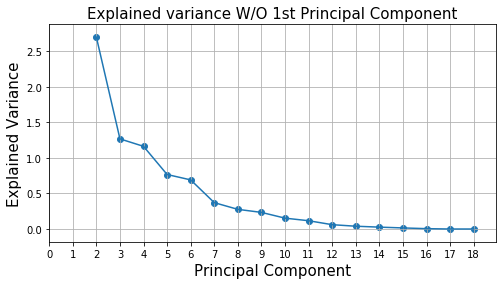

In [15]:
x = np.linspace(1, 18, 18)
plt.figure(figsize=(8, 4)).gca()
plt.plot(x[1:], exp_var[1:])
plt.scatter(x[1:], exp_var[1:])
plt.title('Explained variance W/O 1st Principal Component',fontsize = 15)
plt.xlabel('Principal Component',fontsize = 15)
plt.ylabel('Explained Variance',fontsize = 15)
plt.xticks(np.arange(0,19,step = 1)) # add loads of ticks
plt.grid()

In [16]:
print(pca.explained_variance_)
#print(pca.components_)

[1.01165992e+01 2.70011643e+00 1.26844461e+00 1.16337609e+00
 7.67036496e-01 6.91149828e-01 3.70920126e-01 2.76558608e-01
 2.33729992e-01 1.52828755e-01 1.16457108e-01 6.08711317e-02
 3.91413873e-02 2.63568222e-02 1.51194259e-02 4.92461952e-03
 3.43265438e-06 8.13984108e-08]


Most of the explained variance is given by the 1st element, and then the following 3 are one of order of magnitude smaller, followed by 7 2 orders of magnitude smaller than the first one and last 6 2 and 3 orders of magnitude smaller.

That can be also seen in the analysis below.

## Linear Regression

total_UPDRS ~ pc1 + pc2 + pc3 + pc4 + pc5 + pc6 + pc7 + pc8 + pc9 + pc10 + pc11
                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     87.39
Date:                Mon, 08 Feb 2021   Prob (F-statistic):          1.82e-181
Time:                        11:16:12   Log-Likelihood:                -6589.1
No. Observations:                4954   AIC:                         1.320e+04
Df Residuals:                    4942   BIC:                         1.328e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

Text(0.5, 1.0, 'Residual Histogram')

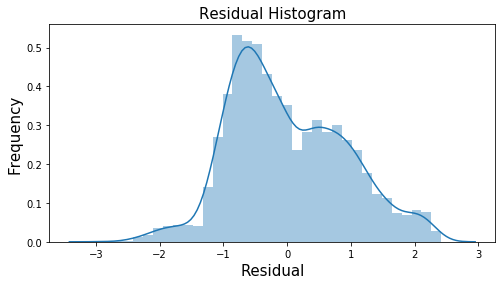

In [17]:
# Perform linear regression with the first N columns.
n = 11

formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end
print(formula_final)

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
plt.figure(figsize=(8, 4)).gca()
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual',fontsize = 15)
plt.ylabel('Frequency',fontsize = 15)
plt.title('Residual Histogram',fontsize = 15)

It is possible to see multiple picks on the Freq Vs Residual plot, which could indicate a multimodal behaviour in our target label or the presence of outliers and/or clusters in our target label. (See plot below)

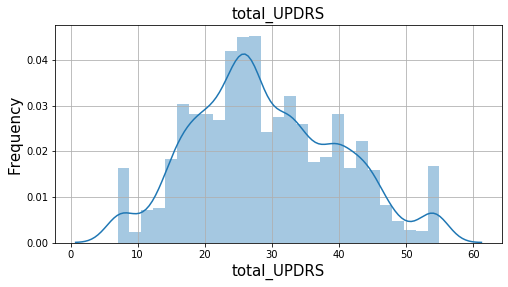

In [18]:
plt.figure(figsize=(8, 4)).gca()
sns.distplot(y, hist=True)
plt.xlabel('total_UPDRS',fontsize = 15)
plt.ylabel('Frequency',fontsize = 15)
plt.title('total_UPDRS',fontsize = 15)
plt.grid()

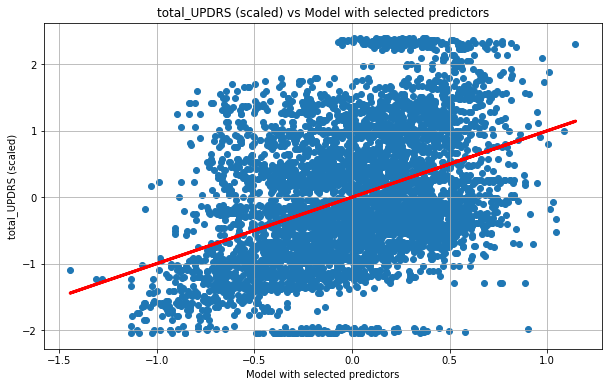

In [21]:
predictions = results.predict() 

def scatters(a,b,c,d):
    plt.figure(figsize=(10, 6)).gca()
    plt.scatter(a, b)
    plt.plot(a, c, linewidth=3, color = 'red')
    plt.grid(True)
    plt.xlabel(d)
    plt.ylabel('total_UPDRS (scaled)')
    plt.title('total_UPDRS (scaled) vs ' + d)

scatters(predictions, y_scaled, predictions, 'Model with selected predictors')

# Summary/Conclusion:

- **Number of components before and after (choose a smaller number of principal components and explain how you chose them):**
    - The number of original components was 18, after doing PCA for the regression it was possible to see that most of the explained variance is given by the 1st element, and then the following (3 elements) are one of order of magnitude smaller, followed by (7 elements) 2 orders of magnitude smaller than the first element and last (7 elements) 2 and 3 orders of magnitude smaller. Therefore it was decided to simply the model by using only the first 11 elements from the PCA analysis and discard the rest. (A small comparison was done to identify the impact on Rsq by choosing this model or the model with all the variables, and the differences were negligible)


- **Interpret the adjusted R-squared:**
    - The R-squared value for the model using the first 11 components was: **0.163** which means that our model is able to explain about 16% of the variation from our data (observations). Which is not necessarily bad since most of our predictors (independent components) are statistically significant predictors.